# Document Retrieval with Bi-Encoder and Cross-Encoder

In this course, we will cover the process of utilizing bi-encoder and cross encoder to retrieve documents relevant to our query

<div style="text-align : center;">
    <img width="800" alt="bi_encoder" src="https://github.com/augustinLib/All-of-NLP/assets/74291999/4c196702-aee7-48b8-8ea9-d655a18bae71">
</div>

## Ready to start

We will use the `sentence-transformers` library to implement the bi-encoder and cross-encoder models. The library provides encoder models that can be used to encode text into embeddings.  

`faiss` is a library that is used to perform similarity search on the embeddings. We will use it to retrieve the most relevant documents to our query.  

For Dataset, we will use the `MS-MARCO` dataset. `MS-MARCO` is a collection of queries and web pages from Bing search, and contains queries and documents that are relevant to the queries.

In [1]:
!pip install -U sentence-transformers
# https://sbert.net/

In [2]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 14.1 MB/s eta 0:00:0000:0100:01


In [3]:
!pip install pandas

In [4]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1i2Sv9ddy3eWZGNN5_oARmPaCEJJfyCE1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1i2Sv9ddy3eWZGNN5_oARmPaCEJJfyCE1" -O valid_document.tsv && rm -rf ~/cookies.txt

--2024-08-15 13:38:38--  https://docs.google.com/uc?export=download&confirm=&id=1i2Sv9ddy3eWZGNN5_oARmPaCEJJfyCE1
Resolving docs.google.com (docs.google.com)... 172.217.161.46, 2404:6800:400a:80e::200e
Connecting to docs.google.com (docs.google.com)|172.217.161.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1i2Sv9ddy3eWZGNN5_oARmPaCEJJfyCE1&export=download [following]
--2024-08-15 13:38:39--  https://drive.usercontent.google.com/download?id=1i2Sv9ddy3eWZGNN5_oARmPaCEJJfyCE1&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.25.161, 2404:6800:4004:813::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.25.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42818680 (41M) [application/octet-stream]
Saving to: ‘valid_document.tsv’

valid_document.tsv  100%[===================>]  40.83M  15.6MB/s 

In [5]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FCEaL3ajZiUWHBbxpR76GVtn7Leladye' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FCEaL3ajZiUWHBbxpR76GVtn7Leladye" -O document_embedding.pkl && rm -rf ~/cookies.txt

--2024-08-15 13:38:50--  https://docs.google.com/uc?export=download&confirm=&id=1FCEaL3ajZiUWHBbxpR76GVtn7Leladye
Resolving docs.google.com (docs.google.com)... 172.217.161.46, 2404:6800:400a:80e::200e
Connecting to docs.google.com (docs.google.com)|172.217.161.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1FCEaL3ajZiUWHBbxpR76GVtn7Leladye&export=download [following]
--2024-08-15 13:38:50--  https://drive.usercontent.google.com/download?id=1FCEaL3ajZiUWHBbxpR76GVtn7Leladye&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.25.161, 2404:6800:4004:813::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.25.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7955107 (7.6M) [application/octet-stream]
Saving to: ‘document_embedding.pkl’

document_embedding. 100%[===================>]   7.59M  19.2M

### About Sentence-transformers
- https://sbert.net/
- https://huggingface.co/sentence-transformers


In [6]:
# import the necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(query_embeddings, document_embeddings, rank_df, document_df):
    retrieved_docid = rank_df.loc[:, 'retrieved_doc']
    # concat
    retrieved_doc = []
    for doc in retrieved_docid:
        retrieved_doc.extend(doc)

    retrieved_doc_index = []
    for doc in retrieved_doc:
        retrieved_doc_index.append(np.where(document_df['docid'].values == doc)[0][0])

    document_embeddings = document_embeddings[retrieved_doc_index]

    # reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, metric='cosine', random_state=42, perplexity=10)  # Adjust the perplexity value here

    embeddings = np.concatenate([query_embeddings, document_embeddings])
    # fit the tsne on the embeddings
    Y = tsne.fit_transform(embeddings)

    # separate the query and document embeddings
    query_embedding = Y[:len(query_embeddings)]
    document_embedding = Y[len(query_embeddings):]

    # build dataframe for visualization
    query_df = pd.DataFrame(query_embedding, columns=['x', 'y'])
    query_df['index'] = [i for i in range(len(query_embedding))]

    document_df = pd.DataFrame(document_embedding, columns=['x', 'y'])
    document_df['index'] = np.repeat(np.arange(len(query_embeddings)), 5)

    # plot the embeddings
    plt.figure(figsize=(5, 5))
    # scatter plot for query embeddings and document embeddings
    # colors are based on the index
    # each color represents a query and its relevant documents
    plt.scatter(query_df['x'], query_df['y'], c=query_df['index'], cmap='tab20', label='Query')
    plt.scatter(document_df['x'], document_df['y'], c=document_df['index'], cmap='tab20', marker='x', label='Document')
    plt.legend()

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-15 13:39:06.824214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 13:39:06.838643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 13:39:06.843172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 13:39:06.854026: I tensorflow/core/platform/cp

In [7]:
# get document data
document = pd.read_csv('valid_document.tsv', sep='\t', dtype=str)
document["docid"] = [int(document.loc[i, "docid"][1:]) for i in range(len(document))]
document
# 문서번호:docid, 문서내용:doc_tac

,docid,doc_tac
0,3500066,Sixth Grade Goals 01of 04Sixth Grade Math Goal...
1,268049,Cashier Job Description Cashier Job Descriptio...
2,1364402,Aluminum sulfate Learn about this topic in the...
3,1829982,"Theory of justification From Wikipedia, the fr..."
4,244077,Basics of Hormone Classification Basics of Hor...
...,...,...
5174,3016113,6.3: Visible-Light Detectors and Instruments S...
5175,1204440,House Republicans Schedule Obama Impeachment H...
5176,1162930,How to Go Through Airport Security Smoothly Re...
5177,34482,GB to MB Conversion Home » Gigabytes Conversio...


In [8]:
# docid -> content function
def get_content(docid):
    return document[document['docid'] == docid]['doc_tac'].values[0]

def print_document(content):
    content = content.split('.')
    for line in content:
        print(line)

def print_query_document(query, docid):
    print("Query: ", query)
    print()
    print("Document Content: ")
    print(get_content(docid))

# Retrieve document with Bi-encoder

### We will first utilize the bi-encoder structure to retrieve 5 documents.  
The 10 documents are the top-5 most relevant documents to the query,  
and the criterion for relevant is the higher the `inner product` between the query embedding and the document embedding.

### The bi-encoder structure is composed of two parts:
- `Document encoder`: encodes the document into an embedding
- `Query encoder`: encodes the query into an embedding

But in this case, we will use the same encoder for both the document and the query.(`parameter sharing`)

In [9]:
# load the pre-trained model
bi_encoder = SentenceTransformer('sentence-transformers/msmarco-MiniLM-L6-cos-v5')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:

# generate embeddings for the document
def generate_embeddings(text):
    return bi_encoder.encode(text)

def get_document_embeddings(document):
    embeddings = []
    for text in tqdm(document):
        embeddings.append(generate_embeddings(text))

    embeddings = np.array(embeddings)
    return embeddings

# document embeddings
# document_embeddings = get_document_embeddings(document['doc_tac'])

with open('document_embedding.pkl', 'rb') as f:
    document_embeddings = pickle.load(f)

In [11]:
# document embeddings shape will be (number of documents, embedding size)
document_embeddings.shape

(5179, 384)

In [12]:
# use faiss to index the embeddings
# when we initialize the index, we need to specify the dimension of the embeddings -> document_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(document_embeddings.shape[1])

# add the document embeddings to the index
faiss_index = faiss.IndexIDMap2(faiss_index)
faiss_index.add_with_ids(document_embeddings, document['docid'].values)

# check the total number of documents in the index -> it will be equal to the number of documents in the document_embeddings
print(faiss_index.ntotal)

5179


## Queries which we will use to retrieve documents
In this example, we will use the following queries to retrieve documents:
- why do people buy cars

- how many square kilometers is scotland's

- what does terrorism mean and example

- what does the term alien mean

- what part of the eye allows light to enter

Ground truth of these queries are:
- 2921145  

- 8041

- 634663

- 1354086

- 24337


Before we perform the document retrieval process for a query, let's look at each query and its corresponding ground truth document

In [13]:
query = [
"why do people buy cars",
"how many square kilometers is scotland's",
"what does terrorism mean and example",
"what does the term alien mean",
"what part of the eye allows light to enter"
]

gt_docid = [
    2921145,
    8041,
    634663,
    1354086,
    24337
]

In [14]:
print_query_document(query[0], gt_docid[0])

Query:  why do people buy cars

Document Content: 
Why Car Buyers Buy Business Journal October 14, 2004Print Why Car Buyers Buyby William J. Mc Ewen Author of Married to the Brand Yet another comprehensive study of auto buyers ignores the enormous impact of consumer emotions A recent study of automobile buyers has concluded that there are only two critical factors that influence car-buying decisions in the United States: "product excellence" and "cost of ownership." According to the Booz Allen consultancy, which conducted the study, these two factors account for about 90% of the perceived differences among alternative vehicle brands. The study, which was the result of an intensive investigation into a decade of automobile buyer data, seems to have crystal clear implications for auto marketers and their ad agencies. As one Booz Allen vice president states, "If the pictures people are seeing don't show the functional attributes of the vehicle, you're wasting your money." Lifestyle and "f

In [15]:
print_query_document(query[1], gt_docid[1])

Query:  how many square kilometers is scotland's

Document Content: 
Information about Scotland Information about Scotland• Facts• Geographic data• Population• Languages• History (separate page)• Climate• Flora and fauna• Economy• Tourism• The Scottish-English conflict• The actual weather Facts about Scotland The (national) flag Official name Gaelic: Alba Officially Scotland is a souvereign part of the United Kingdom, but we it as a country on its own (we are a bit in favour of its independancy). Surface 78.772 km&pos2; (almost 2x as big as the Netherlands)Inhabitants 5.4 million (2016)Population density 67 inhabitants per km&pos2;Capital Edinburgh Currency The Scottish or British pound (GBP); 1 pound was about € 1,50 in April 2003 but in 2017 € 1,18; 1 € = about £ 0,92. Just like Ireland, Scotland has its own state bank en its own en ook eigen banknotes that are sometimes refused in other parts of the United Kingdom. Road network Most roads are good, but there are a lot of single trac

In [16]:
print_query_document(query[2], gt_docid[2])

Query:  what does terrorism mean and example

Document Content: 
Terrorism From Wikipedia, the free encyclopedianavigation search"Terrorist" redirects here. For other uses, see Terrorist (disambiguation). United Airlines Flight 175 hits the South Tower during the September 11 attacks of 2001 in New York City. Terrorism Definitions History Incidents By ideology [show]Structure [show]Methods Tactics [show]Terrorist groups [show]Adherents [show]Response to terrorism [show]v t e Part of a series on War History [show]Battlespace [show]Weapons [show]Tactics [show]Operational [show]Strategy [show]Grand strategy [show]Organization [show]Personnel [show]Logistics [show]Related [show]Lists [show]v t e Terrorism is, in the broadest sense, the use of intentionally indiscriminate violence as a means to create terror among masses of people; or fear to achieve a financial, political, religious or ideological aim. [1] It is used in this regard primarily to refer to violence against peacetime targets o

In [17]:
print_query_document(query[3], gt_docid[3])

Query:  what does the term alien mean

Document Content: 
Definitions &Translations Freebase (0.00 / 0 votes)Rate this definition: Aliens Aliens is a 1986 science fiction action film directed by James Cameron and starring Sigourney Weaver, Carrie Henn, Michael Biehn, Lance Henriksen, William Hope, and Bill Paxton. A sequel to the 1979 film Alien, Aliens follows Weaver's character Ellen Ripley as she returns to the planet where her crew encountered the hostile Alien creature, this time accompanied by a unit of Colonial Marines. Aliens' action-adventure tone was in contrast to the horror motifs of the original Alien. Following the success of The Terminator, which helped establish Cameron as a major action director, 20th Century Fox greenlit Aliens with a budget of approximately $18 million. It was filmed in England at Pinewood Studios and at a decommissioned power plant. Aliens grossed $86 million at the US box office during its 1986 theatrical release and $131 million worldwide. The mov

In [18]:
print_query_document(query[4], gt_docid[4])

Query:  what part of the eye allows light to enter

Document Content: 
About the Eye and How It Works Edited by Maureen A. Duffy, M. S., CVRTAbout the Eye and How It Works Diagram of the eye, viewed from the side. National Eye Institute To understand this diagram of the eye, try to picture it as being split in two, like an apple that's been cut in half. Imagine yourself looking into the eye from the cut side. The Cornea The cornea is a transparent dome-shaped tissue that forms the front part of your eye. It functions as a window and allows light to enter your eye. It also begins the process of focusing light rays that allow you to see words and images clearly. The cornea provides 65-75% of your eye's focusing power. The cornea does not contain any blood vessels, but instead contains many nerve endings that make it extremely sensitive. That is why a scratch or a loose eyelash is so painful. Jake Whalen: Living and Coping with Keratoconus Jake Whalen is a freelance copywriter who has str

In [19]:
# generate embeddings for queries
query_embedding = generate_embeddings(query)
query_embedding = np.array(query_embedding).reshape(len(query), -1)

# query embeddings shape will be (number of query, embedding size)
print(query_embedding.shape)

(5, 384)


In [20]:
# we use faiss index for document search
# Enter the query embedding as a parameter to the "search" method and the top k counts you want to retrieve
distances, indices = faiss_index.search(query_embedding, 5)
print("distance")
print(distances) # Query1 [Top1, Top2, Top3, Top3, Top4, Top5]
print()


print("top-5 index")
print(indices)

distance
[[0.7370493  0.42169207 0.41275677 0.40858114 0.4057914 ]
 [0.54664725 0.47927412 0.41078588 0.40992126 0.36580923]
 [0.64003724 0.41849858 0.35692734 0.33116317 0.3263439 ]
 [0.6499371  0.48412478 0.32033274 0.3049298  0.30179211]
 [0.4208352  0.41113207 0.4049254  0.3891392  0.35849276]]

top-5 index
[[2921145  494065 1457967 2746774 2432640]
 [   8041 2462012 3345756 1193207  344473]
 [ 634663  376045 3122791  117128 1945426]
 [1354086 2583713 3519807 1471961  153651]
 [ 527708  813687   56193   24337 1012014]]


In [21]:
def get_rank(query, indices, gt_docid):
    rank_list = []
    for i in range(len(query)):
        rank = np.where(indices[i] == gt_docid[i])[0][0] + 1
        rank_list.append(rank)

    rank_df = pd.DataFrame({
        "query" : query,
        "retrieved_doc" : list(indices),
        "rank" : rank_list,
    })

    return rank_df

rank_df = get_rank(query=query, indices=indices, gt_docid=gt_docid)
rank_df

# gt_docid = [
#    2921145,
#    8041,
#    634663,
#    1354086,
#    24337
#]

,query,retrieved_doc,rank
0,why do people buy cars,"[2921145, 494065, 1457967, 2746774, 2432640]",1
1,how many square kilometers is scotland's,"[8041, 2462012, 3345756, 1193207, 344473]",1
2,what does terrorism mean and example,"[634663, 376045, 3122791, 117128, 1945426]",1
3,what does the term alien mean,"[1354086, 2583713, 3519807, 1471961, 153651]",1
4,what part of the eye allows light to enter,"[527708, 813687, 56193, 24337, 1012014]",4


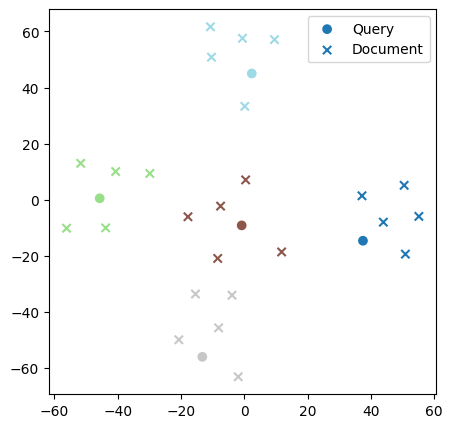

In [22]:
visualize_embeddings(query_embedding, document_embeddings, rank_df, document)

You can see that most of the queries retrieved the ground truth document well with rank 1.  

However, for the last query, the rank is low.  

How can we increase the rank for the last query as well?


# Rerank with Cross-encoder


### Let's rerank the query that didn't achieve rank 1.  

We retrieved the top-5 candidate documents with a bi-encoder structure.  

This time, we will use a slightly more powerful structure, the cross-encoder structure, to rerank the candidate documents.

In [23]:
# cross encoder model
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
# select row whose rank is not 1
not_rank1 = rank_df[rank_df["rank"] != 1].reset_index(drop=True)
not_rank1

,query,retrieved_doc,rank
0,what part of the eye allows light to enter,"[527708, 813687, 56193, 24337, 1012014]",4


In [25]:
# get top-5 document content
content_list = []
top5_docid = not_rank1["retrieved_doc"].values[0]
for docid in top5_docid:
    content_list.append(get_content(docid))

In [26]:
content_list[0]

'Sclera From Wikipedia, the free encyclopedianavigation search Sclera The sclera, as separated from the cornea by the corneal limbus. Details Part of Eye System Visual system Artery anterior ciliary arteries, long posterior ciliary arteries, short posterior ciliary arteries Identifiers Latin Sclera Me SH D012590TA A15.2.02.002FMA 58269Anatomical terminology [ edit on Wikidata]The sclera, [help 1] also known as the white of the eye, is the opaque, fibrous, protective, outer layer of the eye containing mainly collagen and some elastic fiber. [2] In humans, the whole sclera is white, contrasting with the coloured iris, but in other mammals the visible part of the sclera matches the colour of the iris, so the white part does not normally show. In the development of the embryo, the sclera is derived from the neural crest. [3] In children, it is thinner and shows some of the underlying pigment, appearing slightly blue. In the elderly, fatty deposits on the sclera can make it appear slightly 

In [27]:
# for cross encoder convert input to list of tuples (query, document)
cross_input = []
for query in not_rank1["query"]:
    for content in content_list:
        cross_input.append((query, content)) # query : what part of the eye allows light to enter

cross_input[0]

('what part of the eye allows light to enter',
 'Sclera From Wikipedia, the free encyclopedianavigation search Sclera The sclera, as separated from the cornea by the corneal limbus. Details Part of Eye System Visual system Artery anterior ciliary arteries, long posterior ciliary arteries, short posterior ciliary arteries Identifiers Latin Sclera Me SH D012590TA A15.2.02.002FMA 58269Anatomical terminology [ edit on Wikidata]The sclera, [help 1] also known as the white of the eye, is the opaque, fibrous, protective, outer layer of the eye containing mainly collagen and some elastic fiber. [2] In humans, the whole sclera is white, contrasting with the coloured iris, but in other mammals the visible part of the sclera matches the colour of the iris, so the white part does not normally show. In the development of the embryo, the sclera is derived from the neural crest. [3] In children, it is thinner and shows some of the underlying pigment, appearing slightly blue. In the elderly, fatty dep

In [28]:
cross_scores = cross_encoder.predict(cross_input)

In [29]:
cross_scores

array([-5.9132023, -4.0047083, -6.647354 ,  1.8835286, -6.7500825],
      dtype=float32)

In [30]:
docid_score = pd.DataFrame({
    "docid" : top5_docid,
    "score" : cross_scores
})
docid_score = docid_score.sort_values(by="score", ascending=False).reset_index(drop=True)
docid_score

,docid,score
0,24337,1.883529
1,813687,-4.004708
2,527708,-5.913202
3,56193,-6.647354
4,1012014,-6.750082


You can see that the ground truth docid has successfully moved up to rank 1